# 0.0. INITIAL

## 0.1. Imports

In [1]:
# general utilities
import pickle
import inflection
import warnings
from IPython.core.display       import HTML
from IPython.display            import Image
from tabulate                   import tabulate
from GeneralUtils               import GeneralUtils

%matplotlib inline
%pylab inline

warnings.filterwarnings('ignore')

# data manipulation and EDA
import pandas as pd
import math
import numpy as np
import seaborn as sns
import matplotlib
from pandas_profiling           import ProfileReport
from scipy                      import stats            as ss

# preprocessing
from sklearn.preprocessing      import RobustScaler, MinMaxScaler
from imblearn.combine           import SMOTETomek
from sklearn.model_selection import train_test_split

# feature selection
from boruta                     import BorutaPy

# machine learning
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV

# model evaluation
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, cross_val_score
from sklearn.metrics import brier_score_loss, classification_report, roc_curve
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, f1_score
from sklearn.metrics import roc_auc_score, accuracy_score, cohen_kappa_score
from sklearn.metrics import precision_recall_curve, precision_score, recall_score

# model calibration
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

Populating the interactive namespace from numpy and matplotlib


## 0.2. Functions

In [2]:
gu = GeneralUtils()

gu.visual_settings()

## 0.3. Data Load

In [3]:
df_raw = pd.read_csv('C:/Users/lucas/Documents/MeusProjetos/stroke_prediction/data/healthcare-dataset-stroke-data.csv', low_memory = False)

In [4]:
df_raw.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.00,0,1,Yes,Private,Urban,228.69,36.60,formerly smoked,1
1,51676,Female,61.00,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.00,0,1,Yes,Private,Rural,105.92,32.50,never smoked,1
3,60182,Female,49.00,0,0,Yes,Private,Urban,171.23,34.40,smokes,1
4,1665,Female,79.00,1,0,Yes,Self-employed,Rural,174.12,24.00,never smoked,1


# 1.0. DATA DESCRIPTION

In [5]:
df1 = df_raw.copy()

| Feature                                       | Description      |
|:---------------------------|:---------------------------------------------------------------------------|
| id        | unique identifier |
| gender        | "Male", "Female" or "Other" | 
| age        | age of the patient |
| hypertension        | 0 if the patient doesn't have hypertension, 1 if the patient has hypertension | 
| heart_disease        | 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease |
| ever_married   | "No" or "Yes" |
| work_type            |  "children", "Govt_jov", "Never_worked", "Private" or "Self-employed" |
| Residence_type          | "Rural" or "Urban" |
| avg_glucose_level           | average glucose level in blood                                    |
| bmi             | body mass index                                        |
| smoking_status             | "formerly smoked", "never smoked", "smokes" or "Unknown"                 |
| stroke (target)            | 1 if the patient had a stroke or 0 if not                      |

## 1.1. Column's Names

In [6]:
df1.columns

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

## 1.2. Data Dimensions

In [7]:
print('Number of Rows: {}'.format(df1.shape[0]))

print('Number of Columns: {}'.format(df1.shape[1]))

Number of Rows: 5110
Number of Columns: 12


## 1.3. Data Types

In [8]:
df1.dtypes

id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

## 1.4. Check NA

In [9]:
df1.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [10]:
df1[df1['bmi'].isna() ]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1,51676,Female,61.00,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
8,27419,Female,59.00,0,0,Yes,Private,Rural,76.15,NaN,Unknown,1
13,8213,Male,78.00,0,1,Yes,Private,Urban,219.84,NaN,Unknown,1
19,25226,Male,57.00,0,1,No,Govt_job,Urban,217.08,NaN,Unknown,1
27,61843,Male,58.00,0,0,Yes,Private,Rural,189.84,NaN,Unknown,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5039,42007,Male,41.00,0,0,No,Private,Rural,70.15,NaN,formerly smoked,0
5048,28788,Male,40.00,0,0,Yes,Private,Urban,191.15,NaN,smokes,0
5093,32235,Female,45.00,1,0,Yes,Govt_job,Rural,95.02,NaN,smokes,0
5099,7293,Male,40.00,0,0,Yes,Private,Rural,83.94,NaN,smokes,0


## 1.5. Replace NA

In [11]:
round(df1['bmi'].median(), 2)

28.1

In [12]:
df1 = df1.fillna(round(df1['bmi'].median(), 2))

In [13]:
df1.isna().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [14]:
df1.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.00,0,1,Yes,Private,Urban,228.69,36.60,formerly smoked,1
1,51676,Female,61.00,0,0,Yes,Self-employed,Rural,202.21,28.10,never smoked,1
2,31112,Male,80.00,0,1,Yes,Private,Rural,105.92,32.50,never smoked,1
3,60182,Female,49.00,0,0,Yes,Private,Urban,171.23,34.40,smokes,1
4,1665,Female,79.00,1,0,Yes,Self-employed,Rural,174.12,24.00,never smoked,1


In [15]:
# Verification of data equal to zero, some columns presented it but is in line with expectations
# because they are binary variables (0 or 1)
print("# Linhas no dataframe {0}".format(len(df1)))

for i in range(len(df1.columns)):

    j = df1.columns[i]
    print("# Linhas missing {0} : {1}".format(j, len(df1.loc[df1[j] == 0])))

# Linhas no dataframe 5110
# Linhas missing id : 0
# Linhas missing gender : 0
# Linhas missing age : 0
# Linhas missing hypertension : 4612
# Linhas missing heart_disease : 4834
# Linhas missing ever_married : 0
# Linhas missing work_type : 0
# Linhas missing Residence_type : 0
# Linhas missing avg_glucose_level : 0
# Linhas missing bmi : 0
# Linhas missing smoking_status : 0
# Linhas missing stroke : 4861


### 1.6. Descriptive Statistical

In [21]:
# Spliting variables into categorical and numerical ones for analysis
num_attr = df1.select_dtypes(include = ['float64'])
cat_attr = df1.select_dtypes(exclude = ['int64', 'float64'])

#### 1.6.1 Numerical Attributes

In [22]:

summary_stats  = gu.descriptive_statistics(data_set = num_attr)
summary_stats 

,attributes,min,max,range,mean,median,std,skewness,kurtosis
0,age,0.08,82.00,81.92,43.23,45.00,22.61,-0.14,-0.99
1,avg_glucose_level,55.12,271.74,216.62,106.15,91.88,45.28,1.57,1.68
2,bmi,10.30,97.60,87.30,28.86,28.10,7.70,1.09,3.64


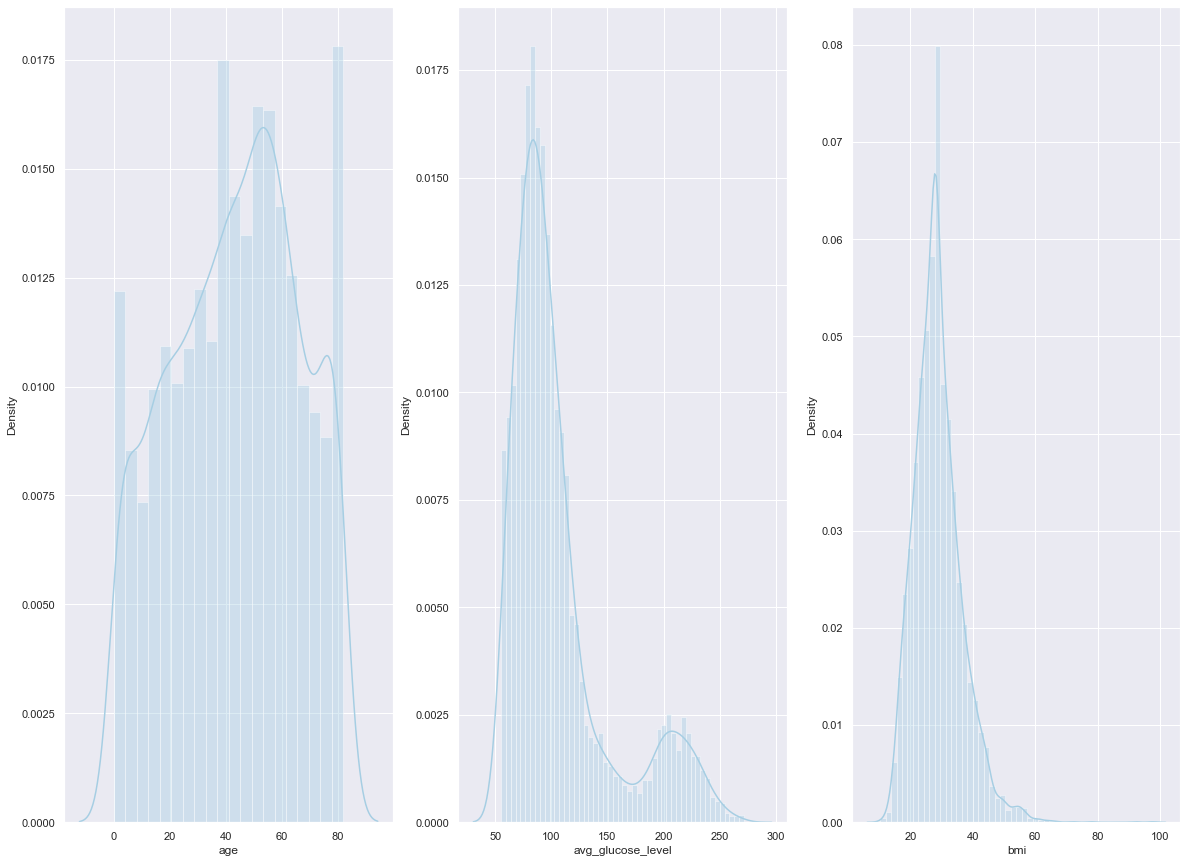

In [23]:
plt.subplot(1, 3, 1)
sns.distplot(df1['age']);

plt.subplot(1, 3, 2)
sns.distplot(df1['avg_glucose_level']);


plt.subplot(1, 3, 3)
sns.distplot(df1['bmi']);

#### 1.6.2 Categorical Attributes

In [19]:
# Discovering how many types each categorical variable has
cat_attr.apply(lambda x: x.unique().shape[0])

gender            3
ever_married      2
work_type         5
Residence_type    2
smoking_status    4
dtype: int64

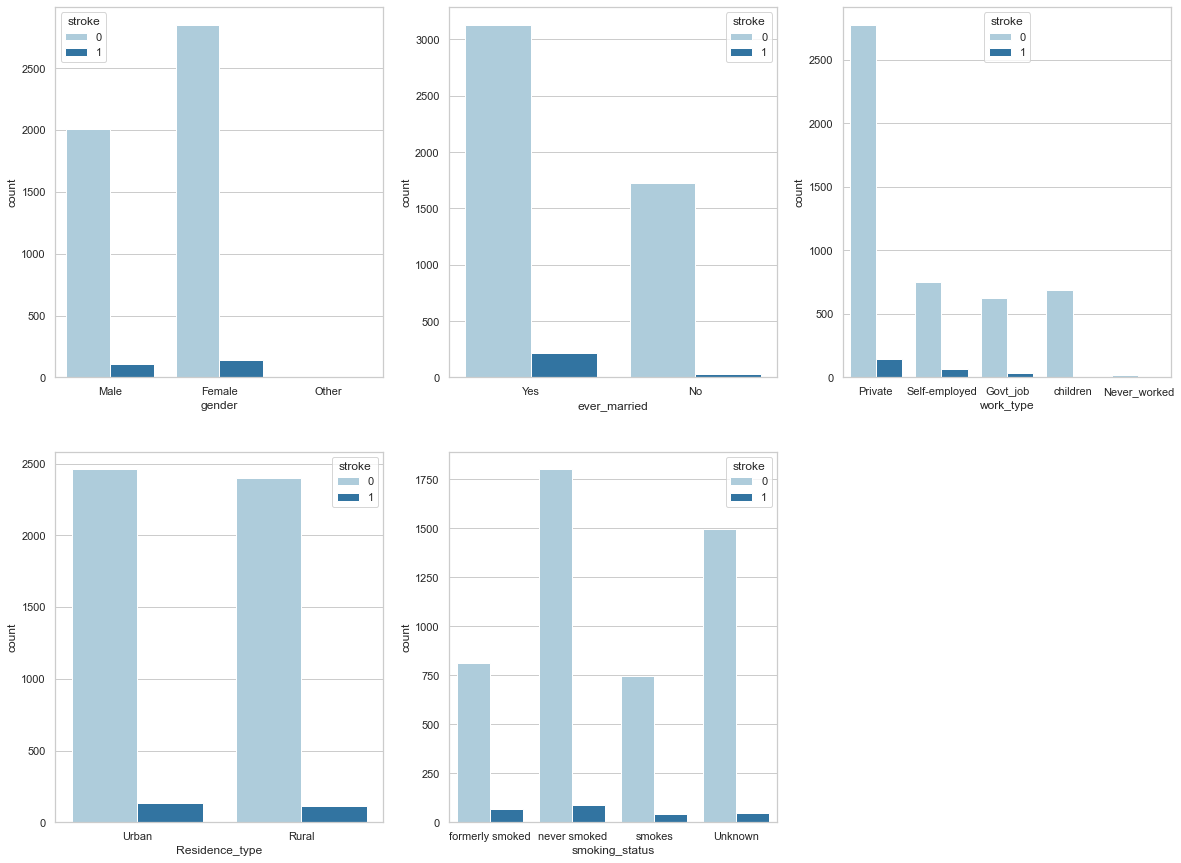

In [34]:
plt.subplot(2, 3, 1)
sns.countplot(data = df1, x = 'gender', hue = 'stroke');

plt.subplot(2, 3, 2)
sns.countplot(data = df1, x = 'ever_married', hue = 'stroke');

plt.subplot(2, 3, 3)
sns.countplot(data = df1, x = 'work_type', hue = 'stroke');

plt.subplot(2, 3, 4)
sns.countplot(data = df1, x = 'Residence_type', hue = 'stroke');

plt.subplot(2, 3, 5)
sns.countplot(data = df1, x = 'smoking_status', hue = 'stroke');

## 2.0. FEATURE ENGINEERING

In [24]:
df2 = df1.copy()

### 2.1. Hypothesis Mind Map

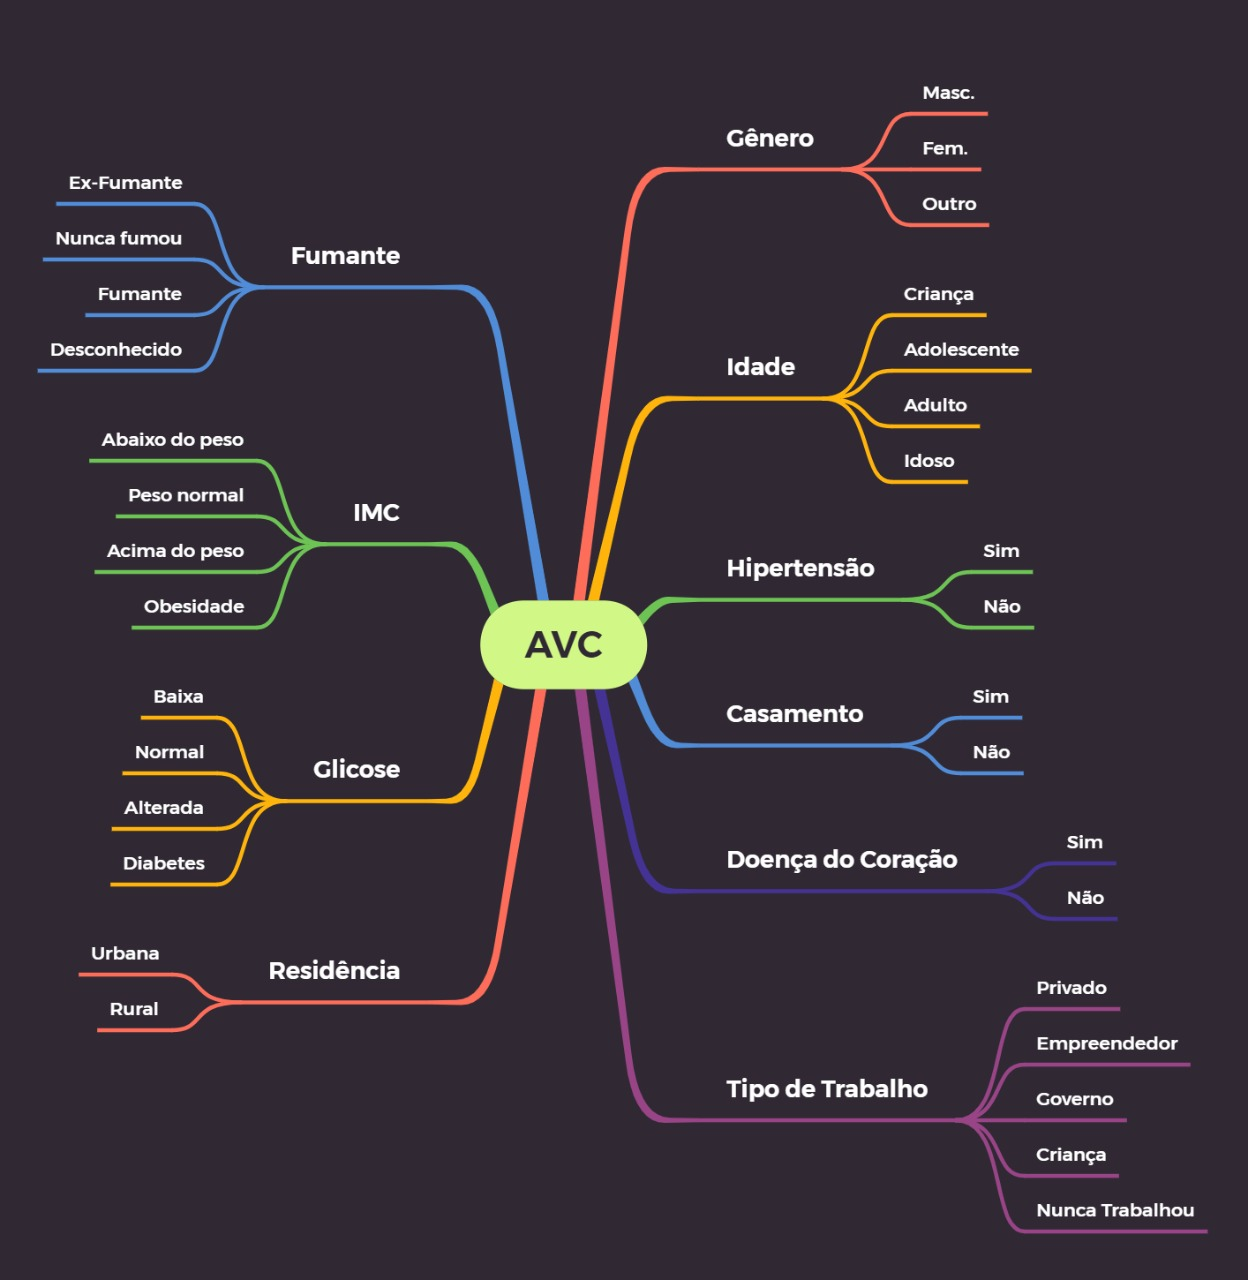

In [25]:
# Hypothesis Mind Map
Image('C:/Users/lucas/Documents/MeusProjetos/stroke_prediction/image/hmm.jpeg')

### 2.2. Hypothesis Creation

Hipóteses Gênero

1 - Homens têm mais chances de ter AVC que mulheres 

Hipóteses Fumante

1 - Fumantes têm mais chances de ter AVC que os demais

2 - Pessoas que nunca fumaram têm menos chances de ter AVC que os demais

Hipóteses Idade

1 - Crianças têm menos chances de ter AVC que os demais

2 - Idosos têm mais chances de ter AVC que os demais

Hipóteses IMC

1 - Pessoas obesas têm mais chances de ter AVC que os demais

2 - Pessoas com peso normal têm menos chances de ter AVC que os demais

Hipóteses Glicose

1 - Pessoas diabéticas têm mais chances de ter AVC que os demais

2 - Pessoas com glicose normal têm menos chances de ter AVC que os demais

Hipóteses Casamento

1 - Pessoas casadas têm mais chances de ter AVC 

Hipóteses Hipertensão

1 - Pessoas hipertensas têm mais chances de ter AVC

Hipóteses Doença do Coração

1 - Pessoas cardíacas têm mais chances de ter AVC

Hipóteses Residência

1 - Pessoas que moram na zona urbana têm mais chances de ter AVC

Hipóteses Tipo de Trabalho

1 - Pessoas empreendedoras têm mais chances de ter AVC que os demais

2 - Crianças têm menos chances de ter AVC que os demais

### 2.3. Feature Engineering

In [26]:
# Dividindo o IMC (BMI) em categorias que possibilitem a análise e validação das hipóteses
df2['weight_status'] = df2['bmi'].apply(lambda x: 'underweight'     if      x < 18.5                else
                                                  'normal_weight'   if      (x >= 18.5) & (x <= 24.9)   else
                                                  'overweight'      if      (x > 24.9) & (x < 30)       else
                                                  'obesity')

In [27]:
# Dividindo o nível de glicose em categorias que possibilitem a análise e validação das hipóteses
df2['glucose_status'] = df2['avg_glucose_level'].apply(lambda x: 'low'          if      x <= 70                 else
                                                                 'normal'       if      (x > 70) & (x < 100)    else
                                                                 'prediabetes'  if      (x >= 100) & (x <= 125) else
                                                                 'diabetes')

In [28]:
# Dividindo as idades em categorias que possibilitem a análise e validação das hipóteses
df2['age_group'] = df2['age'].apply(lambda x:   'children'          if      x <= 16                else
                                                'adult'             if      (x > 16) & (x < 60)       else
                                                'elderly')

## 3.0. VARIABLE FILTERING

In [29]:
df3 = df2.copy()

## 4.0. EXPLORATORY DATA ANALYSIS

In [30]:
df4 = df3.copy()

### 4.1. Univariate analysis

#### 4.1.1 Response Variable

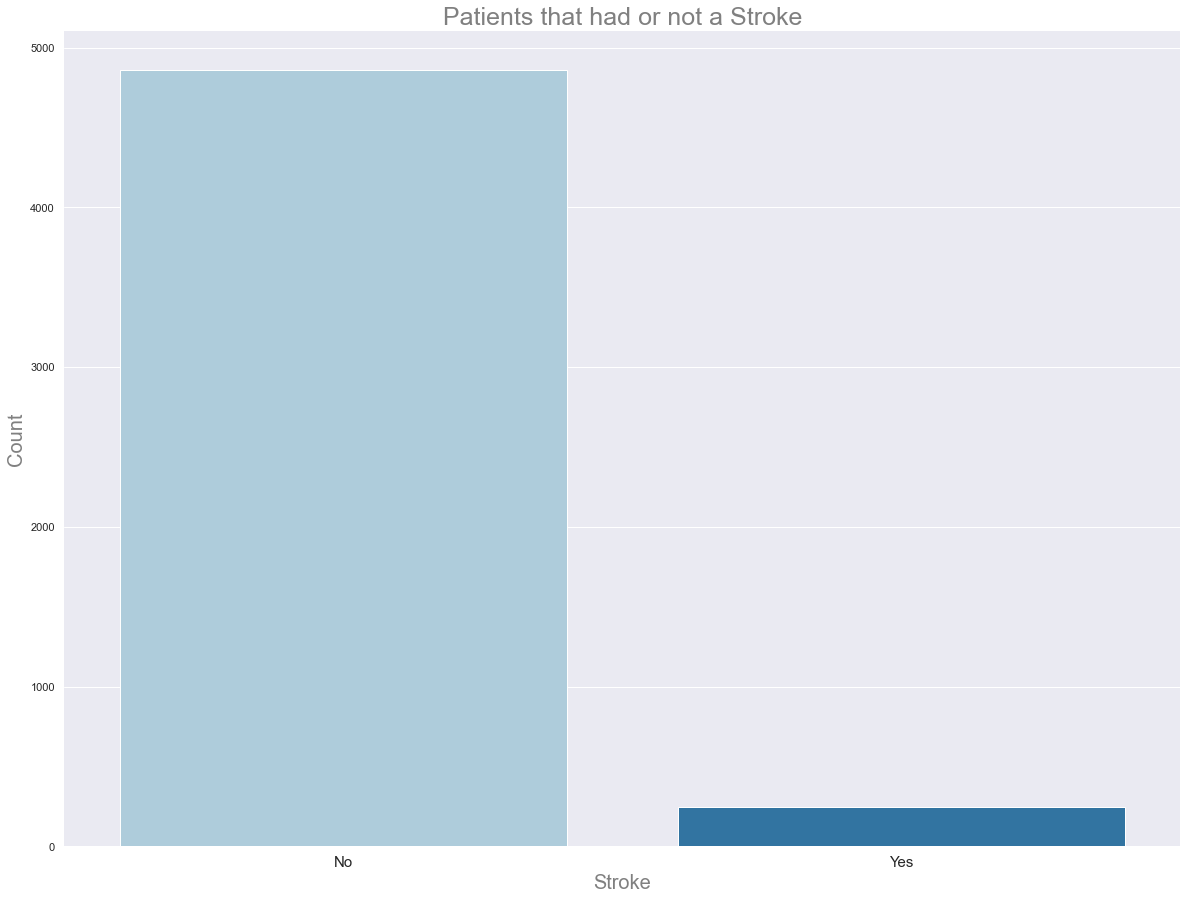

In [31]:
# Percebe-se um significativo desbalanceamento na variável resposta
sns.countplot(data = df4, x = 'stroke');
sns.set_style('whitegrid')
plt.title('Patients that had or not a Stroke', size = 25, color = 'grey')
plt.xlabel('Stroke', size = 20, color = 'grey')
plt.xticks(np.arange(2), labels=['No','Yes'], size = 15)
sns.set_style("whitegrid")
sns.despine( bottom = True, left = True)
plt.ylabel("Count", size = 20, color = 'grey');

#### 4.1.2 Numerical Variables

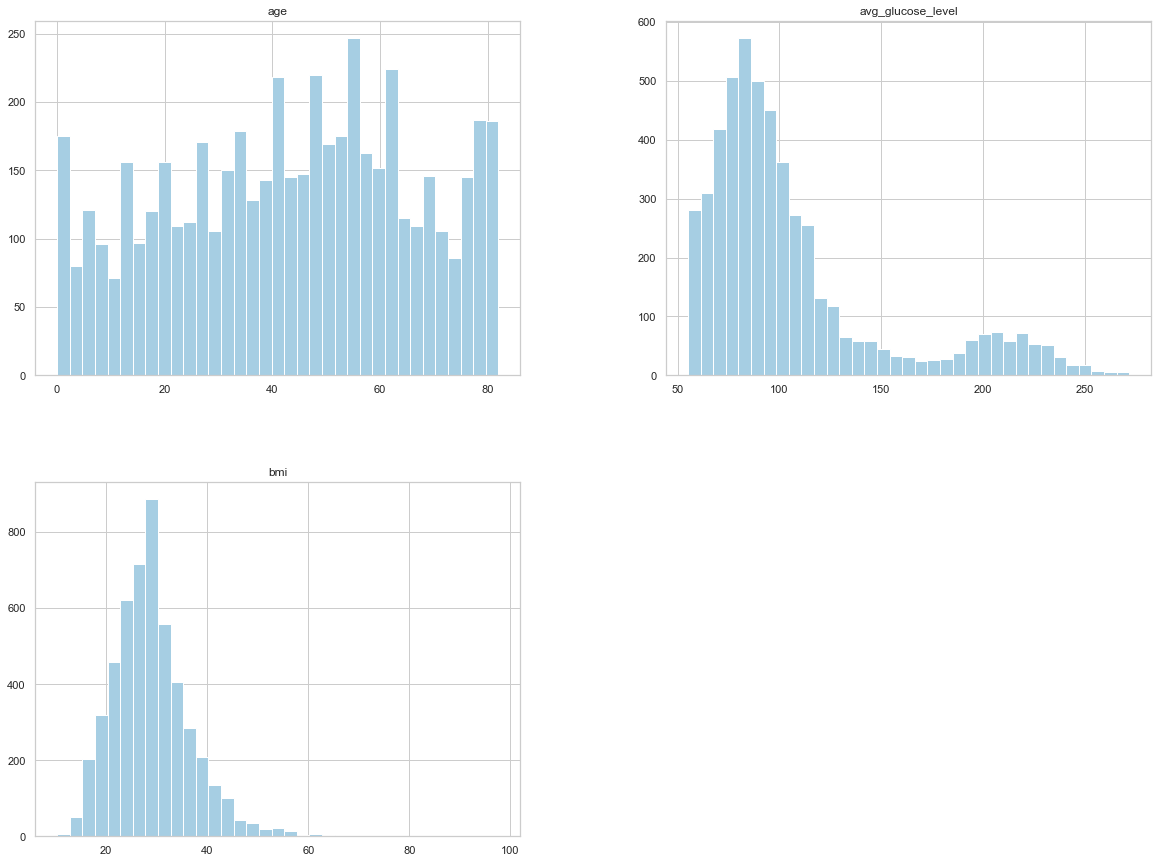

In [32]:
num_attr.hist(bins = 35);

#### 4.1.3 Categorical Variables

<AxesSubplot:xlabel='age_group', ylabel='count'>

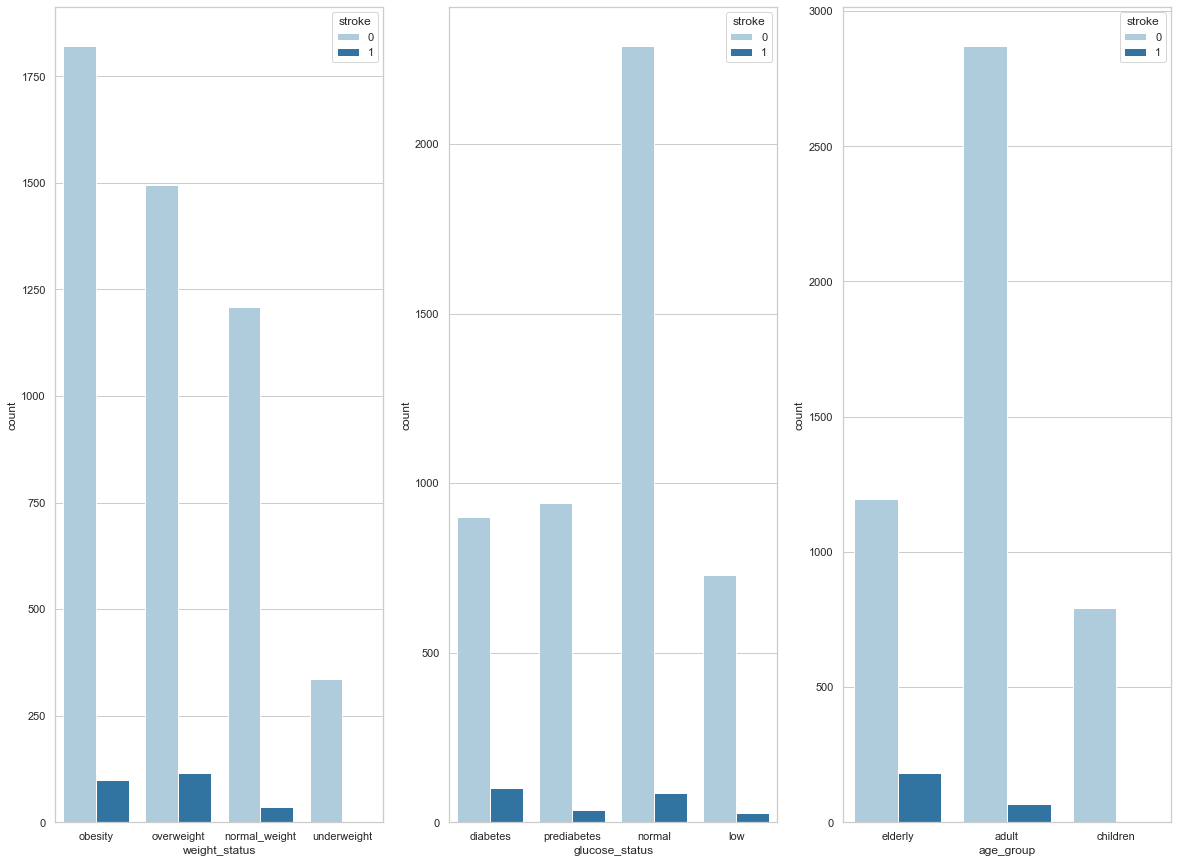

In [33]:
# weight_status
plt.subplot(1, 3, 1)
sns.countplot(data = df4, x = 'weight_status', hue = 'stroke');

# glucose_status
plt.subplot(1, 3, 2)
sns.countplot(data = df4, x = 'glucose_status', hue = 'stroke');

# age_group
plt.subplot(1, 3, 3)
sns.countplot(data = df4, x = 'age_group', hue = 'stroke');


### 4.2. Bivariate analysis - Hypothesis Validation

#### Hipótese 1 - Homens têm mais chances de ter AVC que mulheres 

FALSA - Mulheres tiveram mais AVC que homens

In [35]:
aux = df4[df4['stroke'] == 1][['gender', 'stroke']].groupby('gender').sum().reset_index().sort_values(by = 'stroke', ascending = False)
aux

,gender,stroke
0,Female,141
1,Male,108


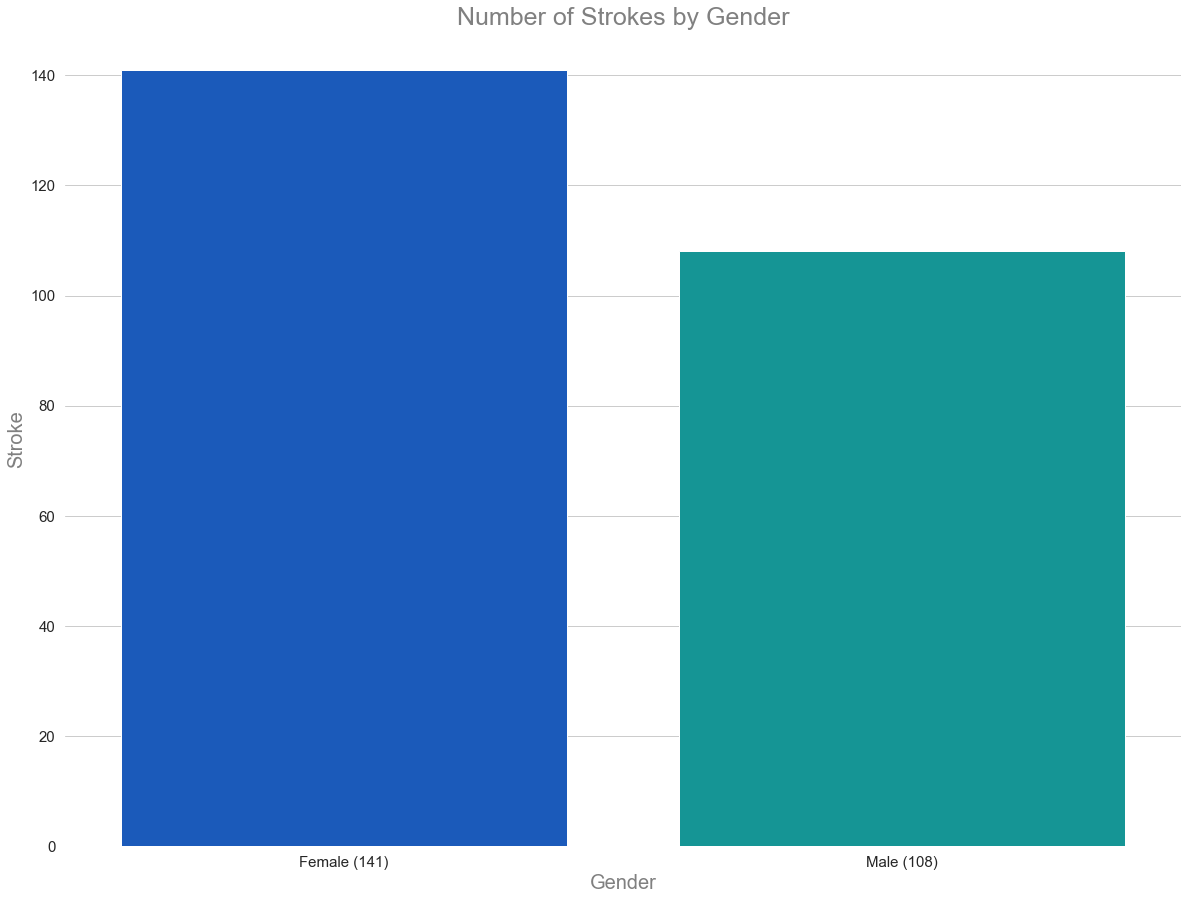

In [36]:
sns.barplot(x = 'gender', y = 'stroke', data = aux, palette = 'winter');
plt.title('Number of Strokes by Gender', size = 25, color = 'grey')
sns.despine(bottom = True, left = True)
plt.xlabel("Gender", size = 20, color = 'grey')
plt.ylabel("Stroke", size = 20, color = 'grey')
plt.xticks(np.arange(2), ['Female (141)', 'Male (108)'], size = 15)
plt.yticks(size = 15);

#### Hipótese 2 - Fumantes têm mais chances de ter AVC que os demais 

FALSA - Fumantes tiveram MENOS AVC

#### Hipótese 3 - Pessoas que nunca fumaram têm menos chances de ter AVC que os demais

FALSA - Pessoas que nunca fumaram tiveram MAIS AVC

In [37]:
aux1 = df4[df4['stroke'] == 1][['smoking_status', 'stroke']].groupby('smoking_status').sum().reset_index().sort_values(by = 'stroke', ascending = False)
aux1

,smoking_status,stroke
2,never smoked,90
1,formerly smoked,70
0,Unknown,47
3,smokes,42


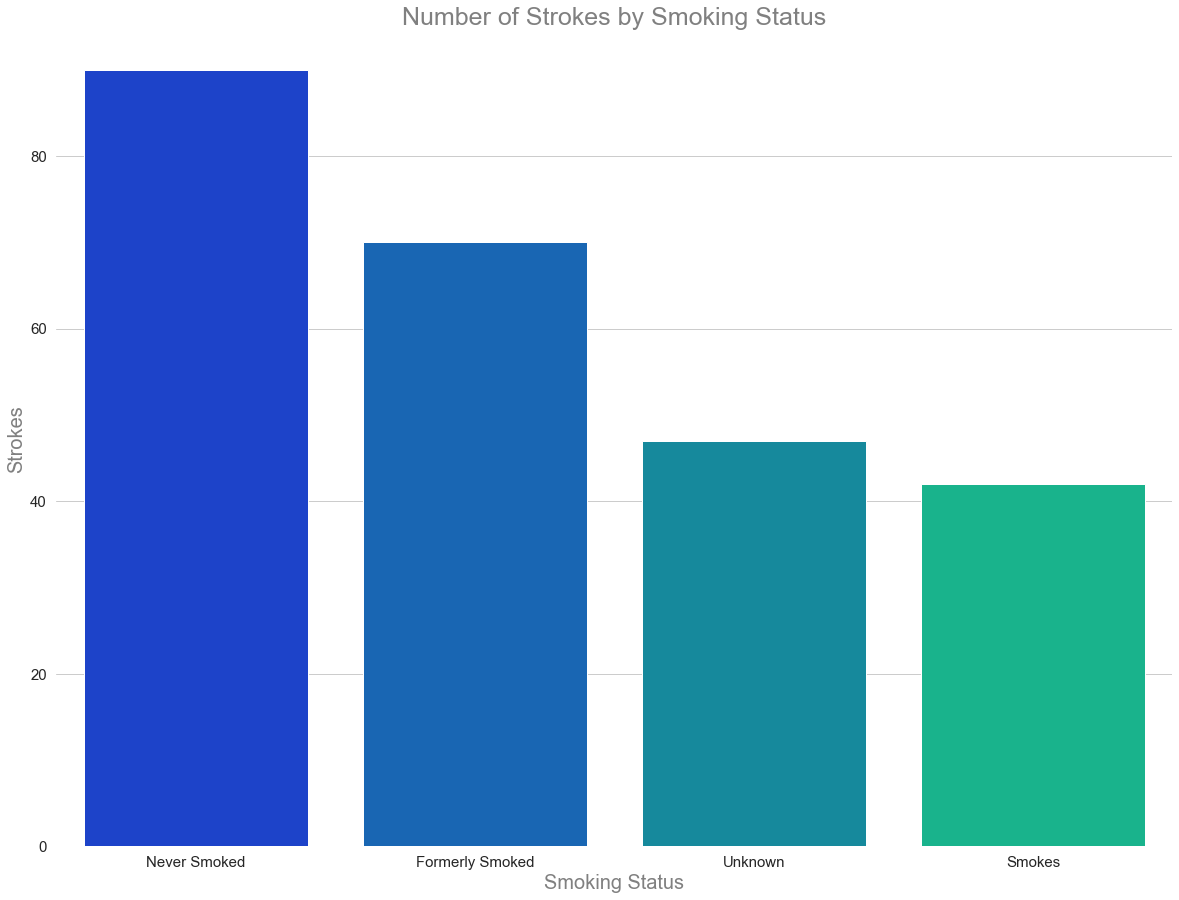

In [38]:
sns.barplot(x = 'smoking_status', y = 'stroke', data = aux1, palette = 'winter')
sns.despine(bottom = True, left = True)
plt.title('Number of Strokes by Smoking Status', size = 25, color = 'gray')
plt.xlabel("Smoking Status", size = 20, color = 'grey')
plt.ylabel("Strokes", size = 20, color = 'grey')
plt.xticks(np.arange(4), ['Never Smoked', 'Formerly Smoked', 'Unknown', 'Smokes'], size = 15)
plt.xticks(size = 15)
plt.yticks(size = 15);

#### Hipótese 4 - Crianças têm menos chances de ter AVC que os demais 

VERDADEIRA - Crianças tiveram MENOS AVC

#### Hipótese 5 - Idosos têm mais chances de ter AVC que os demais

VERDADEIRA - Idosos tiveram MAIS AVC

In [39]:
aux2 = df4[df4['stroke'] == 1][['age_group', 'stroke']].groupby('age_group').sum().reset_index().sort_values(by = 'stroke', ascending = False)
aux2

,age_group,stroke
2,elderly,181
0,adult,66
1,children,2


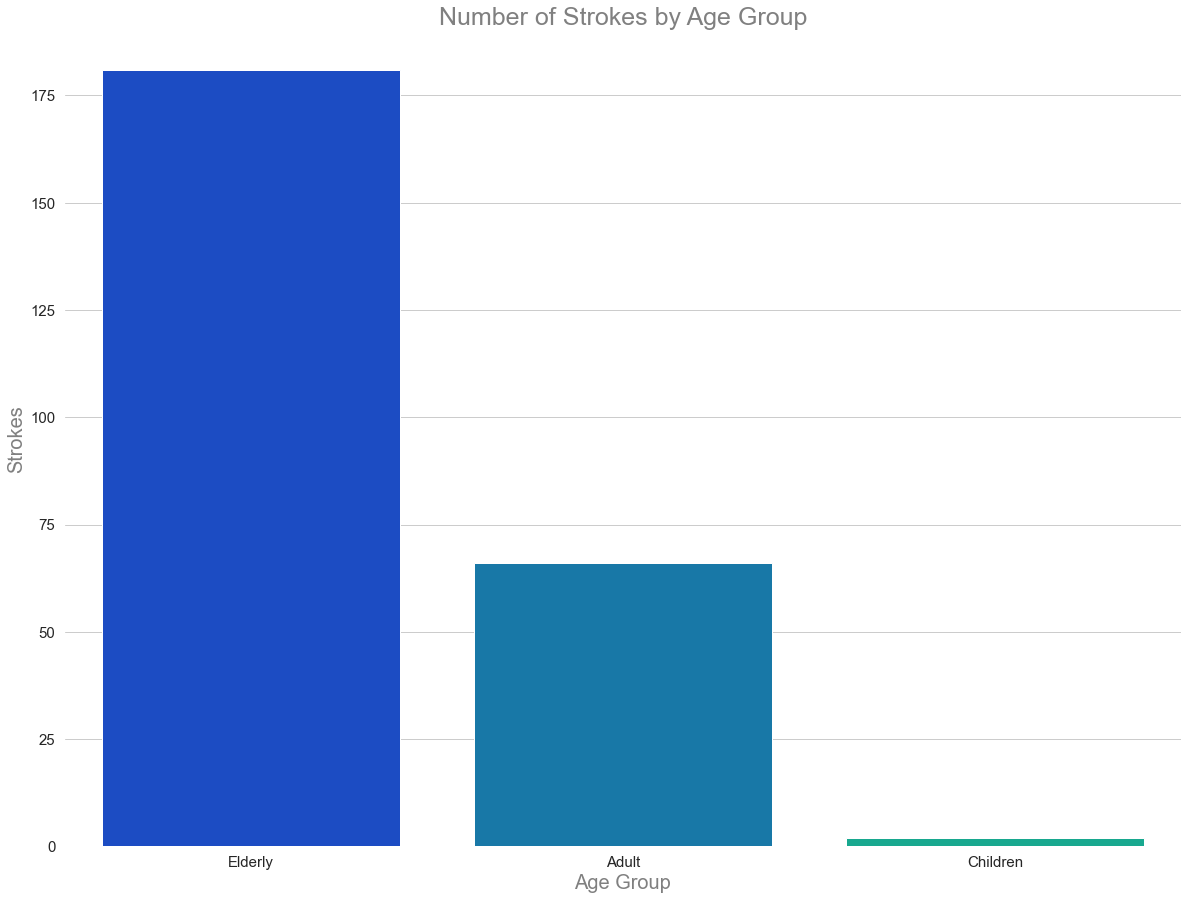

In [40]:
sns.barplot(x = 'age_group', y = 'stroke', data = aux2, palette = 'winter')
sns.despine(bottom = True, left = True)
plt.title('Number of Strokes by Age Group', size = 25, color = 'gray')
plt.xlabel("Age Group", size = 20, color = 'grey')
plt.ylabel("Strokes", size = 20, color = 'grey')
plt.xticks(np.arange(3), ['Elderly', 'Adult', 'Children'], size = 15)
plt.xticks(size = 15)
plt.yticks(size = 15);

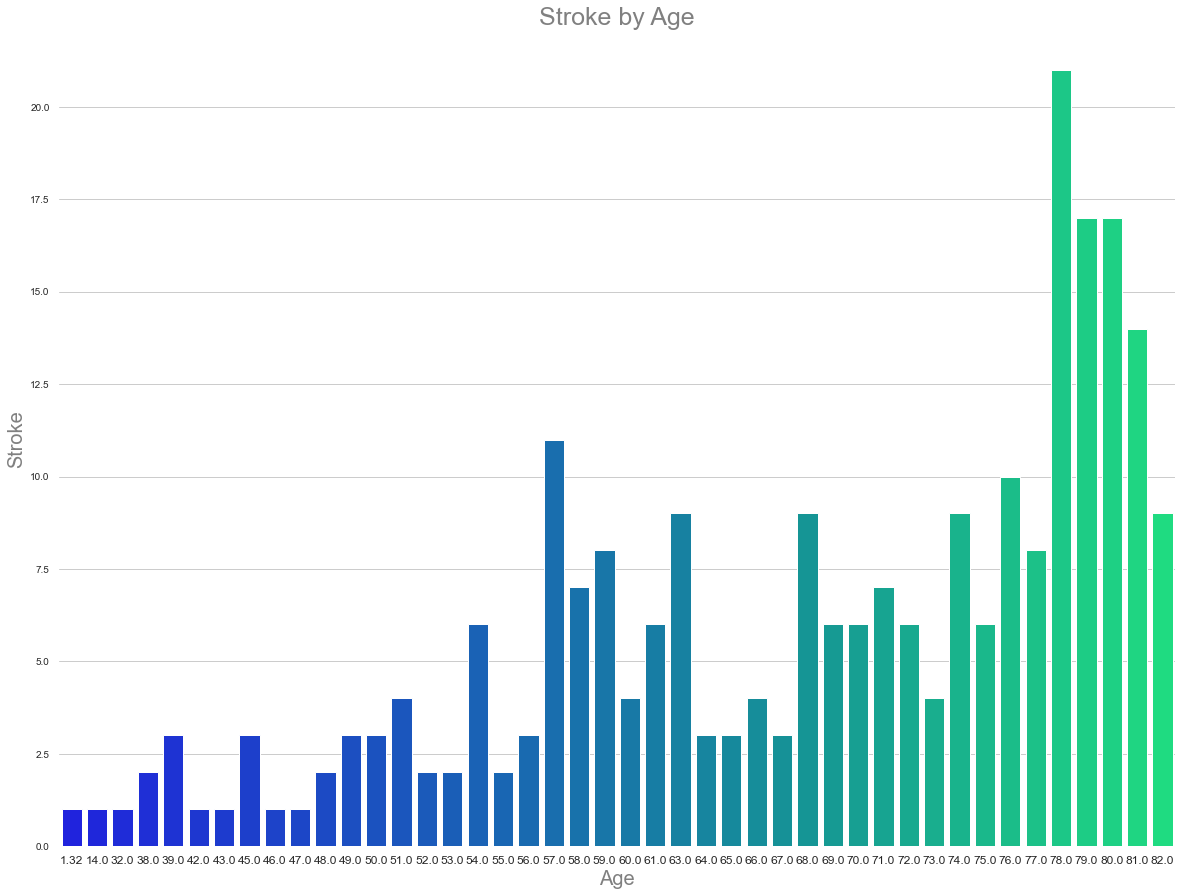

In [41]:
plt.figure(figsize(20,15))
aux3 = df4[df4['stroke'] == 1][['age', 'stroke']].groupby('age').sum().reset_index()
sns.barplot( x = 'age', y = 'stroke', data = aux3, palette = 'winter' );
plt.title('Stroke by Age', size = 25, color = 'grey')
sns.set_style("whitegrid")
sns.despine( bottom = True, left = True)
plt.xticks(size = 12)
plt.yticks(size = 10)
plt.xlabel("Age", size = 20, color = 'grey')
plt.ylabel("Stroke", size = 20, color = 'grey');

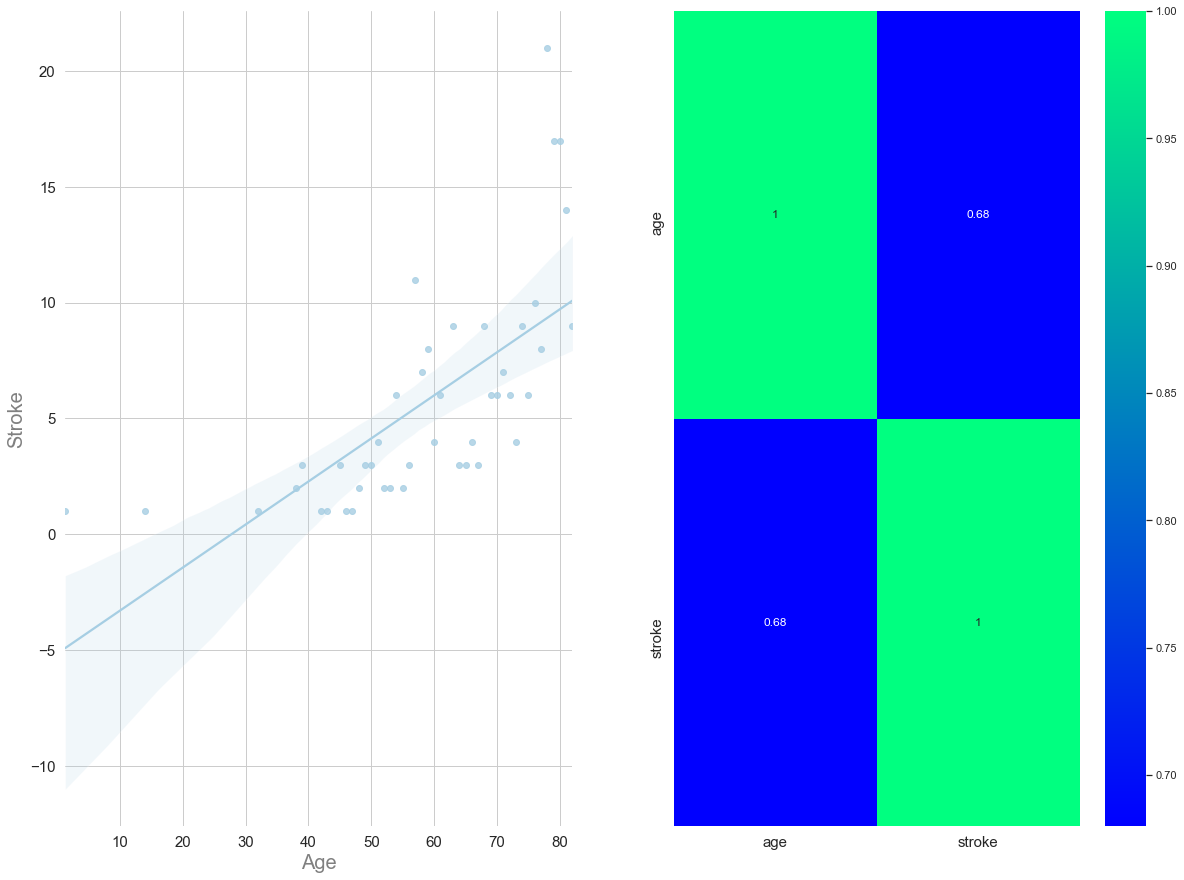

In [42]:
plt.subplot(1, 2, 1)
sns.regplot(x = 'age', y = 'stroke', data = aux3)
sns.despine(bottom = True, left = True)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.xlabel("Age", size = 20, color = 'grey')
plt.ylabel("Stroke", size = 20, color = 'grey')

plt.subplot(1, 2, 2)
sns.heatmap(aux3.corr( method='pearson' ), annot=True, cmap="winter")
sns.despine(bottom = True, left = True)
plt.xticks(size = 15)
plt.yticks(size = 15);

#### Hipótese 6 - Pessoas obesas têm mais chances de ter AVC que os demais

FALSA - Pessoas com sobrepeso tiveram MAIS AVC

#### Hipótese 7 - Pessoas com peso normal têm menos chances de ter AVC que os demais 

FALSA - Pessoas abaixo do peso tiveram MENOS AVC

In [ ]:
aux4 = df4[df4['stroke'] == 1][['weight_status', 'stroke']].groupby('weight_status').sum().reset_index().sort_values(by = 'stroke', ascending = False)
aux4

In [ ]:
sns.barplot( x = 'weight_status', y = 'stroke', data = aux4, palette = 'winter' )
sns.despine( bottom = True, left = True)
plt.title( 'Number of Strokes by Weight', size = 25, color = 'gray')
plt.xlabel("Weight", size = 20, color = 'grey')
plt.ylabel("Strokes", size = 20, color = 'grey')
plt.xticks(np.arange(4), ['Overweight', 'Obesity', 'Normal', 'Underweight'], size = 15)
plt.xticks(size = 15)
plt.yticks(size = 15);

In [ ]:
aux5 = df4[df4['stroke'] == 1][['bmi', 'stroke']].groupby('bmi').sum().reset_index()
plt.subplot(1, 2, 1)
sns.regplot(x = 'bmi', y = 'stroke', data = aux5)
sns.despine(bottom = True, left = True)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.xlabel("BMI", size = 20, color = 'grey')
plt.ylabel("Stroke", size = 20, color = 'grey')

plt.subplot(1, 2, 2)
sns.heatmap(aux5.corr( method='pearson' ), annot=True, cmap="winter")
sns.despine(bottom = True, left = True)
plt.xticks(size = 15)
plt.yticks(size = 15);

#### Hipótese 8 - Pessoas diabéticas têm mais chances de ter AVC que os demais

VERDADEIRA - Pessoas diabéticas tiveram MAIS AVC

#### Hipótese 9 - Pessoas com nível de glicose normal têm menos chances de ter AVC que os demais 

FALSA - Pessoas com nível de glicose baixa tiveram MENOS AVC

In [ ]:
aux6 = df4[df4['stroke'] == 1][['glucose_status', 'stroke']].groupby('glucose_status').sum().reset_index().sort_values(by = 'stroke', ascending = False)
aux6

In [ ]:
sns.barplot(x = 'glucose_status', y = 'stroke', data = aux6, palette = 'winter')
sns.despine(bottom = True, left = True)
plt.title('Number of Strokes by Glucose Status', size = 25, color = 'gray')
plt.xlabel("Glucose Status", size = 20, color = 'grey')
plt.ylabel("Strokes", size = 20, color = 'grey')
plt.xticks(np.arange(4), ['Diabetes', 'Normal', 'Prediabetes', 'Low'], size = 15)
plt.xticks(size = 15)
plt.yticks(size = 15);

In [ ]:
aux7 = df4[df4['stroke'] == 1][['avg_glucose_level', 'stroke']].groupby('avg_glucose_level').sum().reset_index()
plt.subplot(1, 2, 1)
sns.regplot(x = 'avg_glucose_level', y = 'stroke', data = aux7)
sns.despine(bottom = True, left = True)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.xlabel("Glucose Level", size = 20, color = 'grey')
plt.ylabel("Stroke", size = 20, color = 'grey')

plt.subplot(1, 2, 2)
sns.heatmap(aux7.corr( method='pearson' ), annot=True, cmap="winter")
sns.despine(bottom = True, left = True)
plt.xticks(size = 15)
plt.yticks(size = 15);

#### Hipótese 10 - Pessoas casadas têm mais chances de ter AVC 

VERDADEIRA - Pessoas casadas tiveram mais AVC

In [ ]:
aux8 = df4[df4['stroke'] == 1][['ever_married', 'stroke']].groupby('ever_married').sum().reset_index().sort_values(by = 'stroke', ascending = False)
aux8

In [ ]:
sns.barplot(x = 'ever_married', y = 'stroke', data = aux8, palette = 'winter')
sns.despine(bottom = True, left = True)
plt.title('Number of Strokes by Marital Status', size = 25, color = 'gray')
plt.xlabel("Marital Status", size = 20, color = 'grey')
plt.ylabel("Strokes", size = 20, color = 'grey')
plt.xticks(np.arange(2), ['Married', 'Single'], size = 15)
plt.xticks(size = 15)
plt.yticks(size = 15);

#### Hipótese 11 - Pessoas hipertensas têm mais chances de ter AVC 

FALSA - Pessoas hipertensas tiveram MENOS AVC

In [ ]:
aux9 = df4[df4['stroke'] == 1][['hypertension', 'stroke']].groupby('hypertension').sum().reset_index()
aux9

In [ ]:
plt.subplot(1, 2, 1)
sns.barplot(x = 'hypertension', y = 'stroke', data = aux9, palette = 'winter')
sns.despine(bottom = True, left = True)
plt.title('Number of Strokes by Hypertension', size = 25, color = 'gray')
plt.xlabel("Hypertension", size = 20, color = 'grey')
plt.ylabel("Strokes", size = 20, color = 'grey')
plt.xticks(np.arange(2), ['No', 'Yes'], size = 15)
plt.xticks(size = 15)
plt.yticks(size = 15);

plt.subplot(1, 2, 2)
sns.heatmap( aux9.corr( method='pearson' ), annot=True, cmap="winter" )
sns.despine( bottom = True, left = True)
plt.xticks(size = 15)
plt.yticks(size = 15);

#### Hipótese 12 - Pessoas cardíacas têm mais chances de ter AVC 

FALSA - Pessoas cardíacas tiveram MENOS AVC

In [ ]:
aux10 = df4[df4['stroke'] == 1][['heart_disease', 'stroke']].groupby('heart_disease').sum().reset_index()
aux10

In [ ]:
plt.subplot(1, 2, 1)
sns.barplot( x = 'heart_disease', y = 'stroke', data = aux10, palette = 'winter' )
sns.despine( bottom = True, left = True)
plt.title( 'Number of Strokes by Heart Disease', size = 25, color = 'gray')
plt.xlabel("Heart Disease", size = 20, color = 'grey')
plt.ylabel("Strokes", size = 20, color = 'grey')
plt.xticks(np.arange(2), ['No', 'Yes'], size = 15)
plt.xticks(size = 15)
plt.yticks(size = 15);

plt.subplot(1, 2, 2)
sns.heatmap( aux10.corr( method='pearson' ), annot=True, cmap="winter" )
sns.despine( bottom = True, left = True)
plt.xticks(size = 15)
plt.yticks(size = 15);

#### Hipótese 13 - Pessoas que moram na zona urbana têm mais chances de ter AVC 

VERDADEIRA - Pessoas que moram na zona urba tiveram MAIS AVC

In [ ]:
aux11 = df4[df4['stroke'] == 1][['Residence_type', 'stroke']].groupby('Residence_type').sum().reset_index().sort_values(by = 'stroke', ascending = False)
aux11

In [ ]:
sns.barplot(x = 'Residence_type', y = 'stroke', data = aux11, palette = 'winter')
sns.despine(bottom = True, left = True)
plt.title('Number of Strokes by Residence Type', size = 25, color = 'gray')
plt.xlabel("Residence Type", size = 20, color = 'grey')
plt.ylabel("Strokes", size = 20, color = 'grey')
plt.xticks(np.arange(2), ['Urban', 'Rural'], size = 15)
plt.xticks(size = 15)
plt.yticks(size = 15);

#### Hipótese 14 - Pessoas empreendedoras têm mais chances de ter AVC que os demais 

FALSA - Pessoas que trabalham no setor privado tiveram MAIS AVC

#### Hipótese 15 - Crianças têm menos chances de ter AVC que os demais 

VERDADEIRA - Pessoas desempregadas porém que são crianças tiveram MENOS AVC

In [ ]:
aux12 = df4[df4['stroke'] == 1][['work_type', 'stroke']].groupby('work_type').sum().reset_index().sort_values(by = 'stroke', ascending = False)
aux12

In [ ]:
sns.barplot(x = 'work_type', y = 'stroke', data = aux12, palette = 'winter')
sns.despine(bottom = True, left = True)
plt.title('Number of Strokes by Work Type', size = 25, color = 'gray')
plt.xlabel("Work Type", size = 20, color = 'grey')
plt.ylabel("Strokes", size = 20, color = 'grey')
plt.xticks(np.arange(4), ['Private', 'Self-Employed', 'Government Job', 'Children'], size = 15)
plt.xticks(size = 15)
plt.yticks(size = 15);

Hipóteses

1 - Homens têm mais chances de ter AVC que mulheres

2 - Fumantes têm mais chances de ter AVC que os demais

3 - Pessoas que nunca fumaram têm menos chances de ter AVC que os demais

4 - Crianças têm menos chances de ter AVC que os demais

5 - Idosos têm mais chances de ter AVC que os demais

6 - Pessoas obesas têm mais chances de ter AVC que os demais

7 - Pessoas com peso normal têm menos chances de ter AVC que os demais

8 - Pessoas diabéticas têm mais chances de ter AVC que os demais

9 - Pessoas com glicose normal têm menos chances de ter AVC que os demais

10 - Pessoas casadas têm mais chances de ter AVC 

11 - Pessoas hipertensas têm mais chances de ter AVC

12 - Pessoas cardíacas têm mais chances de ter AVC

13 - Pessoas que moram na zona urbana têm mais chances de ter AVC

14 - Pessoas empreendedoras têm mais chances de ter AVC que os demais

15 - Crianças têm menos chances de ter AVC que os demais




In [ ]:
tab =[['Hipóteses', 'Conclusão', 'Relevância'],
      ['H1', 'Falsa', 'Alta'],  
      ['H2', 'Falsa', 'Alta'],  
      ['H3', 'Falsa', 'Alta'],
      ['H4', 'Verdadeira', 'Baixa'],
      ['H5', 'Verdadeira', 'Baixa'],
      ['H6', 'Falsa', 'Alta'],
      ['H7', 'Falsa', 'Alta'],
      ['H8', 'Verdadeira', 'Alta'],
      ['H9', 'Falsa', 'Alta'],
      ['H10', 'Verdadeira', 'Alta'],
      ['H11', 'Falsa', 'Alta'],
      ['H12', 'Falsa', 'Alta'],
      ['H13', 'Verdadeira', 'Alta'],
      ['H14', 'Falsa', 'Baixa'],
      ['H15', 'Verdadeira', 'Alta'],
     ]  
print( tabulate( tab, headers='firstrow' ) )

### 4.3. Multivariate analysis

#### 4.3.1 Numerical Attributes

In [ ]:
correlation = num_attr.corr(method='pearson')
plt.figure(figsize(20,18))
sns.heatmap(correlation, annot=True, annot_kws={"fontsize":14}, cmap='winter')
plt.title("Numerical Attributes Correlation", size=20, color='gray');

#### 4.3.2 Categorical Attributes

In [ ]:
# Calculate cramer V
a1 = cramer_v(cat_attr['gender'], cat_attr['gender'])
a2 = cramer_v(cat_attr['gender'], cat_attr['ever_married'])
a3 = cramer_v(cat_attr['gender'], cat_attr['work_type'])
a4 = cramer_v(cat_attr['gender'], cat_attr['Residence_type'])
a5 = cramer_v(cat_attr['gender'], cat_attr['smoking_status'])

a6 = cramer_v(cat_attr['ever_married'], cat_attr['gender'])
a7 = cramer_v(cat_attr['ever_married'], cat_attr['ever_married'])
a8 = cramer_v(cat_attr['ever_married'], cat_attr['work_type'])
a9 = cramer_v(cat_attr['ever_married'], cat_attr['Residence_type'])
a10 = cramer_v(cat_attr['ever_married'], cat_attr['smoking_status'])

a11 = cramer_v(cat_attr['work_type'], cat_attr['gender'])
a12 = cramer_v(cat_attr['work_type'], cat_attr['ever_married'])
a13 = cramer_v(cat_attr['work_type'], cat_attr['work_type'])
a14 = cramer_v(cat_attr['work_type'], cat_attr['Residence_type'])
a15 = cramer_v(cat_attr['work_type'], cat_attr['smoking_status'])

a16 = cramer_v(cat_attr['Residence_type'], cat_attr['gender'])
a17 = cramer_v(cat_attr['Residence_type'], cat_attr['ever_married'])
a18 = cramer_v(cat_attr['Residence_type'], cat_attr['work_type'])
a19 = cramer_v(cat_attr['Residence_type'], cat_attr['Residence_type'])
a20 = cramer_v(cat_attr['Residence_type'], cat_attr['smoking_status'])

a21 = cramer_v(cat_attr['smoking_status'], cat_attr['gender'])
a22 = cramer_v(cat_attr['smoking_status'], cat_attr['ever_married'])
a23 = cramer_v(cat_attr['smoking_status'], cat_attr['work_type'])
a24 = cramer_v(cat_attr['smoking_status'], cat_attr['Residence_type'])
a25 = cramer_v(cat_attr['smoking_status'], cat_attr['smoking_status'])


# Final dataset
d = pd.DataFrame({'gender': [a1, a2, a3, a4, a5], 
                  'ever_married': [a6, a7, a8, a9, a10],
                  'work_type': [a11, a12, a13, a14, a15],
                  'Residence_type': [a16, a17, a18, a19, a20],
                  'smoking_status': [a21, a22, a23, a24, a25]})
d = d.set_index( d.columns )

plt.figure(figsize(20,18))
sns.heatmap(d, annot=True, annot_kws={"fontsize":14}, cmap='winter')
plt.title("Categorical Attributes Correlation", size=20, color='gray');

## 5.0. DATA PREPARATION

In [ ]:
df5 = df4.copy()

In [ ]:
df5.drop(['id'], axis=1, inplace=True)

In [ ]:
df5['gender'].value_counts()

In [ ]:
# Como só se tem 1 'Other' em 'gender' provavelmente se trata de um erro, então será retirado
df5.drop(df5[df5['gender'] == 'Other'].index, axis = 0, inplace = True)

### 5.1. Scaling Numerical Variables

In [ ]:
plt.subplot(1, 3, 1)
sns.boxplot(df5['age']);

plt.subplot(1, 3, 2)
sns.boxplot(df5['avg_glucose_level']);

plt.subplot(1, 3, 3)
sns.boxplot(df5['bmi']);

In [ ]:
# Aplicarei Min-Max Scaler em 'age' que não possui outliers 
# e Robust Scaler em 'avg_glucose_level' e 'bmi' pois possuem bastante outliers
mms = MinMaxScaler()
rs = RobustScaler()

df5['age'] = rs.fit_transform(df5[['age']].values)

df5['avg_glucose_level'] = mms.fit_transform(df5[['avg_glucose_level']].values)

df5['bmi'] = mms.fit_transform(df5[['bmi']].values)

### 5.2. Encoding Categorical Variables

In [ ]:
# Para 'gender', 'ever_married' e 'Residence_type' como só possuem 2 opcões de variáveis serão transformados por Label Encoder
le = LabelEncoder()

df5['gender'] = le.fit_transform(df5['gender'])

df5['ever_married'] = le.fit_transform(df5['ever_married'])

df5['Residence_type'] = le.fit_transform(df5['Residence_type'])

In [ ]:
# 'work_type', 'smoking_status', 'weight_status', 'glucose_status' e 'age_group' possuem múltiplas variáveis então
# será aplicado frequency encoding

fe_wt = df5['work_type'].value_counts()/len(df5)
fe_wt.to_dict()
df5['work_type'] = df5['work_type'].map(fe_wt)

fe_ss = df5['smoking_status'].value_counts()/len(df5)
fe_ss.to_dict()
df5['smoking_status'] = df5['smoking_status'].map(fe_ss)

fe_ws = df5['weight_status'].value_counts()/len(df5)
fe_ws.to_dict()
df5['weight_status'] = df5['weight_status'].map(fe_ws)

fe_gs = df5['glucose_status'].value_counts()/len(df5)
fe_gs.to_dict()
df5['glucose_status'] = df5['glucose_status'].map(fe_gs)

fe_ag = df5['age_group'].value_counts()/len(df5)
fe_ag.to_dict()
df5['age_group'] = df5['age_group'].map(fe_ag)

## 6.0. FEATURE SELECTION

In [ ]:
df6 = df5.copy()

### 6.1. Split into Train and Test datasets

In [ ]:
x = df6.copy()
x.drop(['stroke'], axis=1, inplace=True)

In [ ]:
y = df6['stroke'].copy()

In [ ]:
x_train, x_test, y_train, y_test = ms.train_test_split(x, y, test_size = 0.3, random_state = 42)

In [ ]:
# Boruta selecionou apenas 2 variaveis, não será utilizado
# # define RandomForestRegressor
# rf_clf = RandomForestClassifier(n_jobs=-1)

# # define Boruta
# boruta = BorutaPy(rf_clf, n_estimators='auto', verbose=2, random_state=42).fit(x_train.values, y_train.values.ravel())

In [ ]:
# cols_selected = boruta.support_.tolist()
# cols_selected_boruta = x_train.iloc[:, cols_selected].columns.to_list()
# cols_selected_boruta

In [ ]:
# x_train_boruta = x_train[cols_selected_boruta].copy()
# x_test_boruta = x_test[cols_selected_boruta].copy()

## 7.0. MACHINE LEARNING MODELING

In [ ]:
df7 = df6.copy()

### 7.1. Balancing data for training

In [ ]:
y_train.value_counts()

In [ ]:
 # defines the resampler
resampler = SMOTETomek(random_state = 42, n_jobs=-1)

# makes the balancing
x_train, y_train = resampler.fit_resample(x_train, y_train)

In [ ]:
y_train.value_counts()

In [ ]:
model1 = LogisticRegression(max_iter=220, random_state=42)
model2 = RandomForestClassifier(random_state=42)
model3 = xgb.XGBClassifier(random_state=42)
model1.fit(x_train, y_train)
model2.fit(x_train, y_train)
model3.fit(x_train, y_train)

In [ ]:
log_reg_predict = model1.predict(x_test)
print("Exatidão (Accuracy): {0:.4f}".format(metrics.accuracy_score(y_test, log_reg_predict)))

In [ ]:
cv = StratifiedKFold(n_splits=10)

 # calculates the cross validation scores
cv_scores = cross_val_score(model1, x_train, y_train, cv = cv, scoring='precision', n_jobs=-1)

# prints the average precision and standard deviation of the scores
print("Average precision: %0.4f (+/- %0.4f)" % (cv_scores.mean(), cv_scores.std() * 2))


# calculates the cross validation scores
cv_scores = cross_val_score(model1, x_train, y_train, cv = cv, scoring='recall', n_jobs=-1)

# prints the average recall and standard deviation of the scores
print("\nAverage recall: %0.4f (+/- %0.4f)" % (cv_scores.mean(), cv_scores.std() * 2))


# calculates the cross validation scores
cv_scores = cross_val_score(model1, x_train, y_train, cv = cv, scoring='f1', n_jobs=-1)

# prints the average f1-score and standard deviation of the scores
print("\nAverage f1-score: %0.4f (+/- %0.4f)" % (cv_scores.mean(), cv_scores.std() * 2))


# calculates the cross validation scores
cv_scores = cross_val_score(model1, x_train, y_train, cv = cv, scoring='roc_auc', n_jobs=-1)

In [ ]:
rf_class_predict = model2.predict(x_test)
print("Exatidão (Accuracy): {0:.4f}".format(metrics.accuracy_score(y_test, rf_class_predict)))

In [ ]:
cv = StratifiedKFold(n_splits=10)

 # calculates the cross validation scores
cv_scores = cross_val_score(model2, x_train, y_train, cv = cv, scoring='precision', n_jobs=-1)

# prints the average precision and standard deviation of the scores
print("Average precision: %0.4f (+/- %0.4f)" % (cv_scores.mean(), cv_scores.std() * 2))


# calculates the cross validation scores
cv_scores = cross_val_score(model2, x_train, y_train, cv = cv, scoring='recall', n_jobs=-1)

# prints the average recall and standard deviation of the scores
print("\nAverage recall: %0.4f (+/- %0.4f)" % (cv_scores.mean(), cv_scores.std() * 2))


# calculates the cross validation scores
cv_scores = cross_val_score(model2, x_train, y_train, cv = cv, scoring='f1', n_jobs=-1)

# prints the average f1-score and standard deviation of the scores
print("\nAverage f1-score: %0.4f (+/- %0.4f)" % (cv_scores.mean(), cv_scores.std() * 2))


# calculates the cross validation scores
cv_scores = cross_val_score(model2, x_train, y_train, cv = cv, scoring='roc_auc', n_jobs=-1)

In [ ]:
xgb_class_predict = model3.predict(x_test)
print("Exatidão (Accuracy): {0:.4f}".format(metrics.accuracy_score(y_test, xgb_class_predict)))

In [ ]:
cv = StratifiedKFold(n_splits=10)

 # calculates the cross validation scores
cv_scores = cross_val_score(model3, x_train, y_train, cv = cv, scoring='precision', n_jobs=-1)

# prints the average precision and standard deviation of the scores
print("Average precision: %0.4f (+/- %0.4f)" % (cv_scores.mean(), cv_scores.std() * 2))


# calculates the cross validation scores
cv_scores = cross_val_score(model3, x_train, y_train, cv = cv, scoring='recall', n_jobs=-1)

# prints the average recall and standard deviation of the scores
print("\nAverage recall: %0.4f (+/- %0.4f)" % (cv_scores.mean(), cv_scores.std() * 2))


# calculates the cross validation scores
cv_scores = cross_val_score(model3, x_train, y_train, cv = cv, scoring='f1', n_jobs=-1)

# prints the average f1-score and standard deviation of the scores
print("\nAverage f1-score: %0.4f (+/- %0.4f)" % (cv_scores.mean(), cv_scores.std() * 2))


# calculates the cross validation scores
cv_scores = cross_val_score(model3, x_train, y_train, cv = cv, scoring='roc_auc', n_jobs=-1)

In [ ]:
# Criando uma Confusion Matrix
print("Confusion Matrix")

print("{0}".format(metrics.confusion_matrix(y_test, log_reg_predict, labels = [1, 0])))
print("")

print("Classification Report")
print(metrics.classification_report(y_test, log_reg_predict, labels = [1, 0]))

In [ ]:
# Criando uma Confusion Matrix
print("Confusion Matrix")

print("{0}".format(metrics.confusion_matrix(y_test, rf_class_predict, labels = [1, 0])))
print("")

print("Classification Report")
print(metrics.classification_report(y_test, rf_class_predict, labels = [1, 0]))

In [ ]:
# Criando uma Confusion Matrix
print("Confusion Matrix")

print("{0}".format(metrics.confusion_matrix(y_test, xgb_class_predict, labels = [1, 0])))
print("")

print("Classification Report")
print(metrics.classification_report(y_test, xgb_class_predict, labels = [1, 0]))